The purpose of this assignment is to explore the 2018 Kaggle ML and DS survey data, and train a multi-class logistic regression classifier to predict a respondent's current yearly compensation. 

*Prepared by: Amr Mohamed (October 31st, 2019)*

# 1 General Information of Imported Data

In this section, we just import import the relevant libraries, read in the data and get a first look at it.

### Install Relevant Libraries

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn

### Import Relevant Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

sns.set_style('whitegrid')
%matplotlib inline 

### Read in Data

In [3]:
trainDF = pd.read_csv('multipleChoiceResponses.csv', low_memory=False, header=[0])

# drop the row with columns descriptions. The descriptions are too long. We'll just work with question numbers as
# they're much shorter
trainDF = trainDF.drop(axis=0, index=0)
#trainDF.head()

In [4]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23859 entries, 1 to 23859
Columns: 395 entries, Time from Start to Finish (seconds) to Q50_OTHER_TEXT
dtypes: object(395)
memory usage: 72.1+ MB


The csv file contains 23859 responses with 395 columns for different questions. Looking at the columns, some are multiple choice, many are selections, and a few give the respondents the option to type in responses. 

# 2 Data Exploration and Cleaning 

In this section, we'll plot a few basic graphs to better understand the data, and make a few decisions with regards to data cleaning based on what they show us. We'll also do some very preliminary manual feature selection based on first looks at the data.

Let's make a count plot of the salary brackets, and add another feature which does not many different options as the hue. We can use the gender column as the hue. The graph is shown below

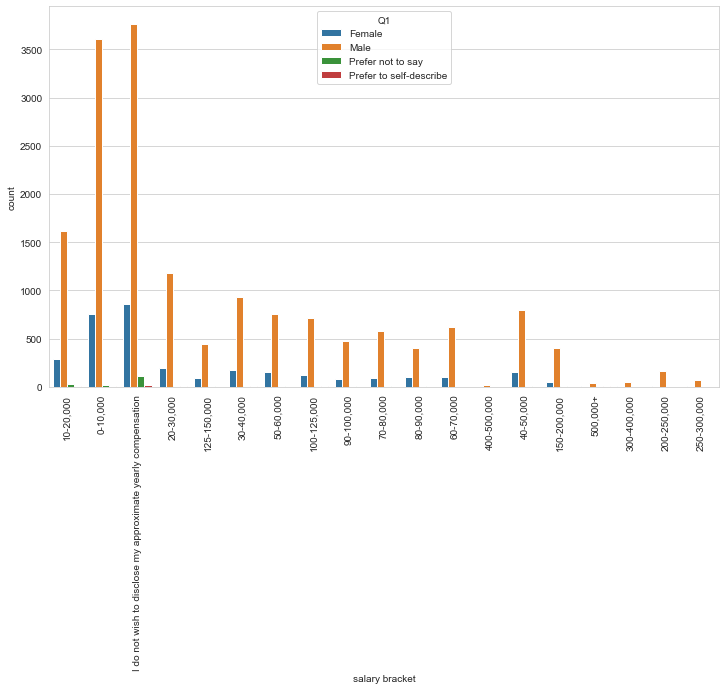

In [5]:
plt.figure(figsize=(12,7))
sns.countplot(x='Q9', hue='Q1', data=trainDF)
plt.xticks(rotation=90)
plt.xlabel('salary bracket')
plt.show()

We can see that many of the respondents did not disclose their salary information. It will be hard to reliably fill in their salaries, so we will just drop their instances. We can see from the count that we'll still have alot of data to train our model on. We'll also be well above the 5k training instances required in the assignment.

The majority of the surveyed were Male. However, the distribution of salaries of both sexes looks very similar, scaling for the count. 
A very small minority of the surveyed did not disclose gender, so we don't lose much by dropping them as well just for the sake of reducing post-encoding features. *(To elaborate: after encoding the data, each option in the each column will be a feature of it's own)*

While we're here, we'll also drop the columns with user inputted text as they will have many words for which a bag-of-words model will be most suitable. We want our focus to be on performing logisitic regression on as little important features as possible. The column names for text input typically have the words 'other' or 'text' in them. Finally, we'll remove the first column ('Time from Start to Finish') since it won't give us any insight on the respondent salary.

All of this is done in the next cell.

In [6]:
trainDF = trainDF[~trainDF['Q9'].fillna(0).isin([0, 'I do not wish to disclose my approximate yearly compensation'])]
trainDF = trainDF[~trainDF['Q1'].fillna(0).isin([0, 'Prefer not to say', 'Prefer to self-describe'])]
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('OTHER')], axis=1)
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('TEXT')], axis=1)
trainDF = trainDF.drop(axis = 1, columns = trainDF.columns[0])

Let's **engineer** a numerical column with the salaries so that we can make nice box plots to gain more quantitative insight about the salaries. To do so, we'll just have another column 'salary' with the higher salary in each salary bracket.

In [7]:
trainDF['salary'] = [int(np.char.split(s, '-').tolist()[-1].
                              replace(',000', '').replace('+', ''))*1000 for s in trainDF['Q9']]

trainDF['salary'].describe()

count     15246.000000
mean      56937.885347
std       64791.726863
min       10000.000000
25%       10000.000000
50%       30000.000000
75%       80000.000000
max      500000.000000
Name: salary, dtype: float64

The mean global salary of the data sample is USD 57k and the median in USD 30k. The maximum salary of 500k is well above the 75 percentile - these might be an alert of outliers in the data. Let's proceed to see if we can do anything about these outliers. 

Let's plot a box plot of salaries by country.

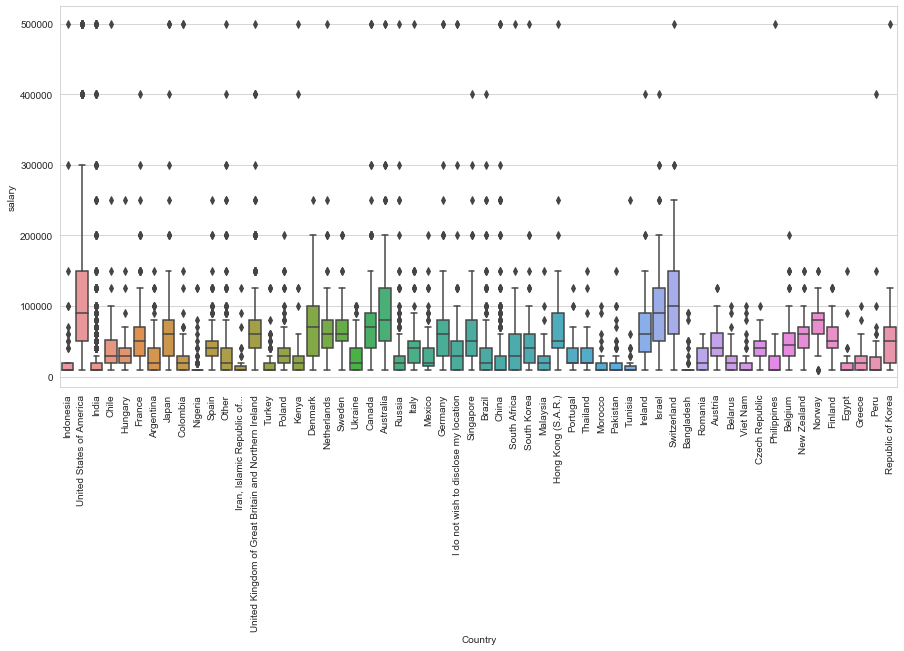

In [8]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Q3', y='salary', data=trainDF)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.show()

There are outliers as we expected. Let's clean out the outliers so that they do not skew our logisitic regression model in any way. To do so we'll just delete the outliers beyond the whiskers of the box plots in the figure above, but using a more lenient multiplier of 1.75 instead of the 1.5 which is typically used. We do that in the next cell, and then we'll plot again to see how it looks.

In [9]:
for y in np.unique(trainDF['Q3']):
    q3 =  trainDF[trainDF['Q3'] == y]['salary'].quantile(0.75)
    trainDF = trainDF[~((trainDF['Q3'] == y) & (trainDF['salary'] > 1.5*q3))]

Understandably, the plot shows that the mean salary that a data scientist earns depends on where he/she works, with the US and Switzerland having the highest mean salaries. 

There are many countries. Can we group them into groups? A quick and dirty method is to group them into classes based on the mean salary shown above. The classes are from I to IV. A dictionary with every country and its chosen class is made below.

We've **engineered** a new feature using the country and salary features showing the levels of pay in different countries. Let's call the new column/feature 'country class'.

In [10]:
countries = np.unique(trainDF.Q3)
mean_countries = [np.mean(trainDF[trainDF.Q3 == y]['salary']) for y in countries]

# sort them in ascending order
countries = np.array(countries)[np.argsort(mean_countries)]
mean_countries = np.array(mean_countries)[np.argsort(mean_countries)]

new_dict = dict()
for i in range(0, countries.shape[0]):
    if mean_countries[i] <= 25000:
        new_dict[countries[i]] = 'I'
    elif mean_countries[i] <= 50000:
        new_dict[countries[i]] = 'II'
    elif mean_countries[i] <= 75000:
        new_dict[countries[i]] = 'III'
    else:
        new_dict[countries[i]] = 'IV'
        
print(new_dict)

trainDF['country class'] = [new_dict[y] for y in trainDF.Q3]

del new_dict, countries, mean_countries

{'Bangladesh': 'I', 'Nigeria': 'I', 'Tunisia': 'I', 'Iran, Islamic Republic of...': 'I', 'Indonesia': 'I', 'Egypt': 'I', 'Pakistan': 'I', 'Viet Nam': 'I', 'India': 'I', 'Morocco': 'I', 'Turkey': 'I', 'Philippines': 'I', 'Peru': 'I', 'China': 'I', 'Kenya': 'I', 'Malaysia': 'I', 'Colombia': 'I', 'Greece': 'I', 'Belarus': 'I', 'Russia': 'I', 'Argentina': 'I', 'Thailand': 'I', 'Other': 'I', 'Brazil': 'I', 'Ukraine': 'I', 'Portugal': 'II', 'Romania': 'II', 'Hungary': 'II', 'Mexico': 'II', 'Poland': 'II', 'I do not wish to disclose my location': 'II', 'Chile': 'II', 'Italy': 'II', 'South Africa': 'II', 'Spain': 'II', 'Czech Republic': 'II', 'South Korea': 'II', 'Austria': 'II', 'Belgium': 'II', 'Republic of Korea': 'II', 'France': 'II', 'Finland': 'II', 'Singapore': 'II', 'Japan': 'II', 'New Zealand': 'II', 'Germany': 'III', 'United Kingdom of Great Britain and Northern Ireland': 'III', 'Netherlands': 'III', 'Hong Kong (S.A.R.)': 'III', 'Sweden': 'III', 'Ireland': 'III', 'Canada': 'III', 'De

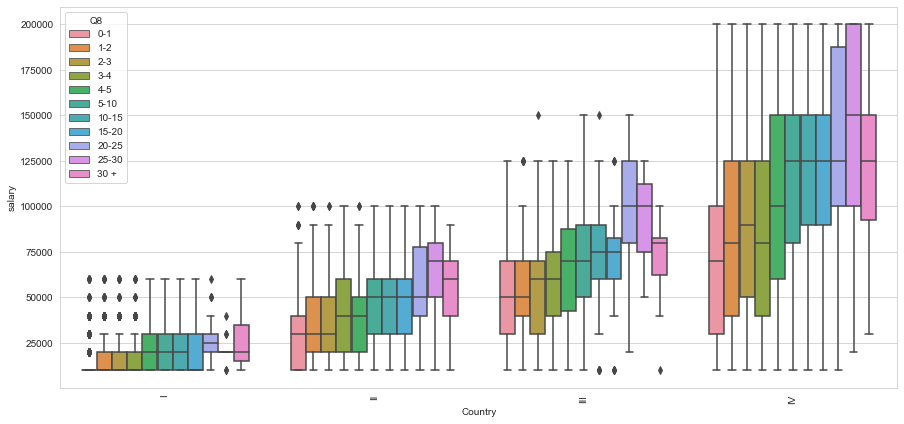

In [11]:
trainDF['yrs_exp'] = [int(np.char.split(str(s).replace('+',''),'-').tolist()[0]) for s in trainDF.Q8.fillna(0)]

plt.figure(figsize=(15,7))
sns.boxplot(x='country class', y='salary', hue='Q8', data=trainDF.sort_values(['country class','yrs_exp'], axis=0))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.show()

trainDF = trainDF.drop(axis = 1, columns = 'yrs_exp')

We can see that there is a postive correlation between the engineered feature and the salary that a person gets, as well as the years of experience a person has and the salary that he gets in each class. 

Let's look at one more box plot. This time we'll have the independent axis show the industry. 

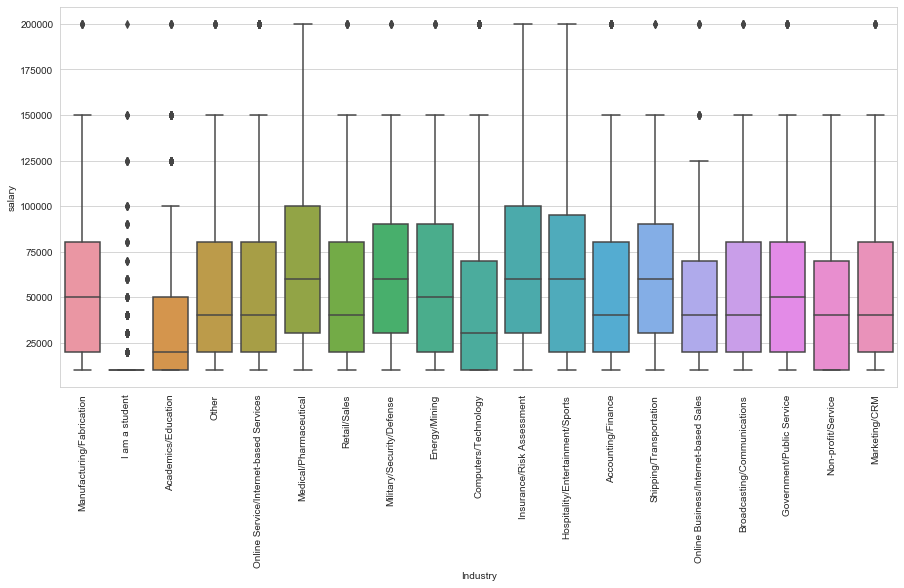

In [12]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Q7', y='salary', data=trainDF)
plt.xticks(rotation=90)
plt.xlabel('Industry')
plt.show()

It looks like the industry might not be an important feature given that there is little difference between the mean salary across industries.

We want to look at the salaries of people in industry. Students and academics seem to show results of respondents who are not earning money or are earning small research fellowships. So let's remove the rows showing their responses.

In [13]:
trainDF = trainDF[~trainDF['Q7'].isin(['I am a student', 'Academics/Education'])]

#### NaN values 

Let's now look at all the samples that have NaN values in the Pandas dataframe in the multiple choice columns.

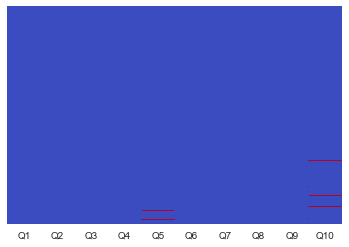

In [14]:
sns.heatmap(trainDF.iloc[:,range(0,10)].isnull(), cmap='coolwarm', yticklabels=False, cbar=False)
plt.show()

We have a few missing in columns Q5 and Q10 which are most likely because the respondents forgot to fill them in.

Q5 is the column with study major answers. We can probably use the respondent's other selections to fill in for the missing values. A thought that comes to mind is using Q6(: role in company) to fill in for it.

Below is a bar chart of the roles in industry hued by the study major. You'll see that each role will typically have a study program which people typically major in, shown by a peaking bar. We can use this information to fill in for the missing study majors. *We'll use the role of the respondent to fill in for their missing study major with the major with which most of the people holding similar roles graduate.*

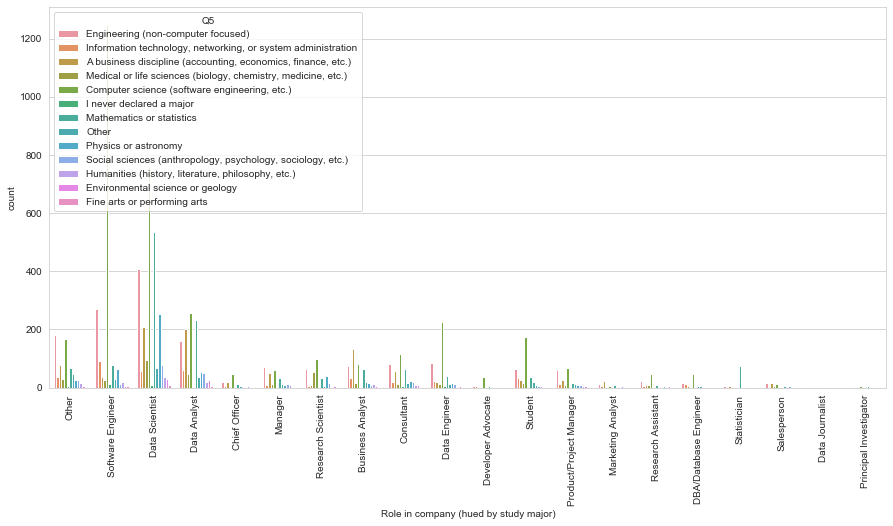

In [15]:
plt.figure(figsize=(15,7))
sns.countplot(x='Q6', hue='Q5', data=trainDF)
plt.xticks(rotation=90)
plt.xlabel('Role in company (hued by study major)')
plt.show()

In [16]:
def fixNaNQ5(major, role):
    global trainDF
    if major == major:
        return major
    else:
        temp_array, temp_count = np.unique(trainDF[trainDF['Q6'] == role]['Q5'].
                  fillna(''), return_counts = True)
        return temp_array[np.argmax(temp_count)]
    
trainDF['Q5'] = trainDF.apply(lambda row: fixNaNQ5(row['Q5'],row['Q6']),axis=1)   

# Verify
trainDF[trainDF['Q5'].isnull()]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,salary,country class


Similarly, we can use the Q7(: industry) to fill in for the missing Q10(: Does your current employer incorporate machine learning methods into their business?) values. 

In [17]:
def fixNaNQ10(use, industry):
    global trainDF
    
    if use == use:
        return use
    else:
        temp_array, temp_count = np.unique(trainDF[trainDF['Q7'] == industry]['Q10'].
                  fillna(''), return_counts = True)
        return temp_array[np.argmax(temp_count)]
    
trainDF['Q10'] = trainDF.apply(lambda row: fixNaNQ10(row['Q10'],row['Q7']),axis=1)

# Verify
trainDF[trainDF['Q10'].isnull()]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,salary,country class


#### Selection empty fields

Now we turn to the selections features. Missing values exist here just because the respondents didn't choose that option. We'll just convert each option to a seperate column/feature with ones where the respondent selected the option and 0 elsewhere. All multiple choice options will also be converted to seperate columns for each multiple choice option with ones where the respondent selected the option and 0 elsewhere. To do this, we'll use the get_dummies function. 

This form of one-hot encoding is used, instead of using label encoding, because no one option is 'greater than' another. The problem with label encoding is that it assumes that the higher the categorical value, the better the category, and we don't want that.

First, let's do more housecleaning and remove the last few text columns that we don't want to use. This includes the countries columns since we already engineered a new feature from it. 

We will also drop out our salary column (target) from the training data since this will be the last time we deal with the training data before it is encoded.

In [18]:
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('Q26')], axis=1)
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('Q34')], axis=1)
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('Q35')], axis=1)
trainDF = trainDF.drop(columns = trainDF.columns[trainDF.columns.str.contains('Q47_Part_16')], axis=1)

# dropping country column since we have a new engineered feature
trainDF = trainDF.drop(columns = 'Q3', axis=1)

In [19]:
y = trainDF['Q9']
trainDF = trainDF.drop(columns = ['Q9'], axis=1)

X = trainDF.drop(columns = ['salary'], axis=1)

In [20]:
def dummify():
    """ Encodes the training data in preparation for running the logistic model """
    
    global X
    
    index = 0
    for i in range(0,X.shape[1]):
        # Create dummy features for each categorical feature
        temp_df = pd.get_dummies(X[X.columns[index]], 
                                 prefix=X.columns[index])
        # Add the new features to the dataframe via concatination
        X = pd.concat([X, temp_df], axis=1)
        if temp_df.shape[1] > 1:
            # Drop one of each of the dummy variables because its value is implied
            # by the other dummy variable columns
            X = X.drop(axis=1, columns = temp_df.columns[-1])
        # Drop the original categorical feature columns
        X = X.drop(axis=1, columns = X.columns[index])
    
dummify()

In [21]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9595 entries, 2 to 23857
Columns: 345 entries, Q1 to country class
dtypes: int64(1), object(344)
memory usage: 25.6+ MB


Now our data is ready for the model. We have 9595 rows

### Summary of what was done in this section
- We deleted rows in which the salary was not disclosed. 
- We performed some manual feature selection, removing columns where the respondents entered text, and columns that do not give inisght on the salary 
- We engineered a numerical salary column to start making box plots of salary 
- We saw that the country in which you work and the number of years of experience you have are likely to impact how much your salary is. Your industry less so.
- We engineered a new feature, country class, to group countries into classes based on salary. This new feature has a strong positive correlation with the salary. 
- We filled in for missing study major values using the job role of the respondent, and for machine learning use in company based on the industry the company is in.
- We used one-hot encoding to prepare the data for out logisitic classification model.

# 3 Building the Logistic Regression Model

First, lets split the data into a training and validation set, with a 70%-30% split. We do this with the train_test_split function. Since we have a good number of training instances, we'll also split the training data again, with a 85%-15% split into a training and validation sets. I will perform k-cross validation as asked in the assignment but this validation set is to perform quick checks and tests. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.15)

We'll then scale the values using StandardScaler() and then fit the logistic regression model

In [23]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
model = LogisticRegression()    
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

We can now use the model that we created to make predictions on the testing set we created earlier.

In [26]:
predictions = model.predict(X_val)
ACC = accuracy_score(y_val, predictions)

print ("This model got an accuracy of {}% on the validation set".format(round(ACC*100,2)))   

This model got an accuracy of 25.6% on the testing set


# 4 Feature Selection

Studying the coefficients of the weights of the L2 regularized model can give us insight on the order of importance of the variables. The heatmap is a visualiziation of the order of importance of some of the features. 

We will next sort the weights to get a look at the strongest features. 

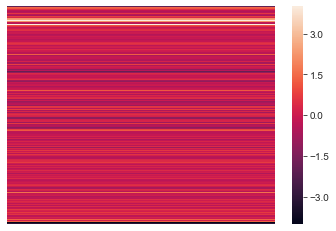

In [27]:
from sklearn.preprocessing import scale
sns.heatmap(scale(np.array(pd.DataFrame(np.transpose((model.coef_))).
                           sum(axis=1)).reshape(-1,1)), yticklabels=0, xticklabels=0, vmin=-4, vmax=4)

In [28]:
print ("Most important 10 features")
print (X.columns[np.array(np.argsort(pd.DataFrame
                                    (np.transpose(np.abs(model.coef_))).
                                    sum(axis=1)))[range(-10,0)]])

print ("Least important 10 features")
print (X.columns[np.array(np.argsort(pd.DataFrame
                                    (np.transpose(np.abs(model.coef_))).
                                    sum(axis=1)))[range(0,10)]])

Most important 10 features
Index(['Q8_0-1', 'Q5_Engineering (non-computer focused)', 'Q6_Other',
       'Q6_Data Analyst', 'Q18_Python', 'Q6_Software Engineer',
       'Q6_Data Scientist', 'country class_III', 'country class_II',
       'country class_I'],
      dtype='object')
Least important 10 features
Index(['Q29_Part_18_Google Fusion Tables', 'Q36_Part_5_DataQuest',
       'Q33_Part_2_University research group websites', 'Q38_Part_1_Twitter',
       'Q20_lightgbm', 'Q21_Part_11_Lattice', 'Q30_Part_16_Snowflake',
       'Q6_Data Journalist', 'Q21_Part_9_Geoplotlib', 'Q32_Categorical Data'],
      dtype='object')


The country classes we engineered make 3 of the 10 most important features, showing that the country you choose to work in is a very imporant factor in determining your pay. Working in data scientist or software engineer role land high up there too. Python seems like the most important tool for data scientists as it is the only language in the top 10 features. 

On the other hand, knowledge of lightgbm or Snowflake don't seem to help factor much in determining a DS salary.

Next we show that dropping the least important features will have a small impact on the accuracy of the model, validating this method as a way to study feature importance. 

In [29]:
Xm = X.drop(columns = X.columns[np.array(np.argsort(pd.DataFrame
                                    (np.transpose(np.abs(model.coef_))).
                                    sum(axis=1)))[range(-301,0)]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(Xm, y, random_state=42, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.15)

del Xm 

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

model = LogisticRegression()    
model.fit(X_train, y_train)

predictions = model.predict(X_val)
    
ACC = accuracy_score(y_val, predictions)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 22.62% on the testing set


We dropped the number of features from 551 to 250, and got a small reduction in accuracy of only 3%.

### Importance of feature selection
Observe how we were able to ignore more than half of the data we have and still achieve a similar accuracy. The practical advantage of this is reduction in training time (learning time via GD) and memory use. We can now also interpret the important features better since we no longer have to deal with the unimportant ones. 
*Why we were able to do so?* Not all of the data is important. Some are redundant. Some are completely useless. Being able to select features helps separate the good features from the unimportant ones.

Moving forward we'll just use L1 regularization to select important features for its sparsity.

# 5 Model Implementation and Optimization

We will now build several models with different regularization values and then select the most optimal model based on predication accuracy. To speed this, we will not use K-fold cross validation for the hyperparameter selection, but we'll instead just test the model's accuracy on the validation set. We'll use K-fold cross-validation in the next section to test the selected model.

The LogisticRegression() function takes in the parameter C which is inverse of regularization strength. Smaller values of C specify stronger regularization or lower model complexity. 

A more complex model will overfit to the training data, and in the process, will be able to capture more fine-grained details in the training set. The training error will hence decrease. The more complex the model, the lower the bias of the model since it will be able to make closer predictions to the training set true labels. However, change the training set slightly, and you might throw off the model. 

This is the bias-variance trade-off, the more fine-grained details the model captures, the more sensitive it is to changes in the training data. We say that the variance error of the model is high, and it might not be able to generalize to test data. 

In this section, we'll address this tradeoff by finding C which achieves the highest accuracy by a grid search. We'll also compare L1- and L2-regularization. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.15)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [31]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

The error rates have been hand-typed into arrays since we commented out the above code. The plot below can help show us the performance of the different hyperparameters. As can be seen, our lowest error rate happens with L1-regularization at C=0.025. This is the model we'll carry forward.

#### Discussion of bias-variance as related to the plot 
Going from right to left on the plot, the model complexity increases. Observe how the error rate decrease as we increase the complexity. This is due to the decrease in bias. At the same time, the variance error of the model in increasing. It is at 0.025 for the L1-reg model, that the growth in variance error dominates any decrease happening in the bias error, and the error rate starts increasing. The L2-reg model shows the same behavior.



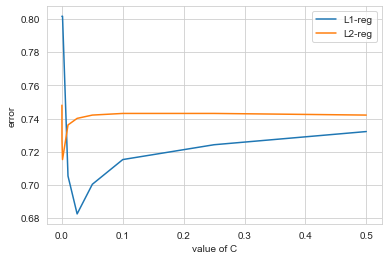

In [32]:
plt.plot([0.00001,0.0001,0.001,0.001,0.01,0.025,0.05,0.1,0.25,0.5],[0.8015873, 0.8015873, 0.8015873, 0.8015873 , 0.70535714, 0.68253968, 0.70039683, 0.71527778,
       0.72420635, 0.73214286], label='L1-reg')
plt.plot([0.00001,0.0001,0.001,0.001,0.01,0.025,0.05,0.1,0.25,0.5],[0.74801587, 0.72718254, 0.71527778, 0.71527778, 0.73611111, 0.74007937, 0.74206349, 0.74305556,
       0.74305556, 0.74206349], label='L2-reg')
plt.xlabel('value of C')
plt.ylabel('error')
plt.legend()
plt.show()


# 6 Model Testing

In this section, we'll further test our best model from the previous section via 10-fold cross validation to calculate an average accuracy and variance for it. The code in this section has been mostly copied from the logisitc regression example posted by the course staff as allowed by the course instructor.

Our model achieves an average accuracy of 31% with a standard deviation of 4.5%. 

# 7 Testing and Discussion

In this section, we'll run our model on the test set, to see how we've done, and 

In [35]:
model = LogisticRegression(C=0.025, penalty='l1')    
model.fit(X_train, y_train)
    
predictions = model.predict(X_val)
ACC = accuracy_score(y_val, predictions)

print ("This model got an accuracy of {}% on the validation set".format(round(ACC*100,2))) 

predictions = model.predict(X_train)
ACC = accuracy_score(y_train, predictions)

print ("This model got an accuracy of {}% on the training set".format(round(ACC*100,2))) 

predictions = model.predict(X_test)
ACC = accuracy_score(y_test, predictions)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2))) 

This model got an accuracy of 31.68% on the testing set
This model got an accuracy of 31.75% on the validation set
This model got an accuracy of 34.76% on the training set


The model actually achieves a relatively high accuracy on the testing set. 
The model had not overfit, since a symptom of overfitting to training data is a very low accuracy when the model sees new data. However, the test accuracy is similar to what had been shown by the K-fold cross validation, and is very close to the accuracy on the training set.

I wouldn't say the model is underfitting either. One may think that since the accuracy is still relatively low, then the model's bias is high and it is underfit. However, I do not think that a logistic regression classifier is a good option for the given data. I don't think that you can get a high accuracy on the given data using linear boundary decision. Decision trees, or kNN seem much better fits. Even an ensemble of logistic classifiers can be considered. 

One other way to better the performance of the model in the case that a logisitic regression classifier is what needs to be used is by using lesser/bigger salary brackets, by increasing the range of pay inside each salary bracket. 

My justification: the model calculates probabilities for the test instance being in each salary bracket before picking the bracket corresponding to the maximum probability. An example is shown in the figure below for an instance that was correctly predicted to bracket 0: 0-10,000.  

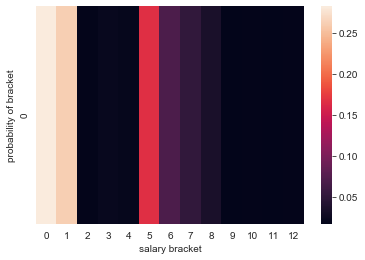

0-10,000


In [43]:
sns.heatmap(model.predict_proba(X_test[1,:].reshape(1,-1)))
plt.xlabel('salary bracket')
plt.ylabel('probability of bracket')
plt.show()

print (y_test.iloc[1])

Since the brackets are tight, expecially the ones below 6-figure salary, the model can mistakenly predict a bracket that is very close to the true one. The model was not correct but it was very close. This is evident in the next example where the model predicted bracket 1 with high probability when it should have predicted bracket 0.

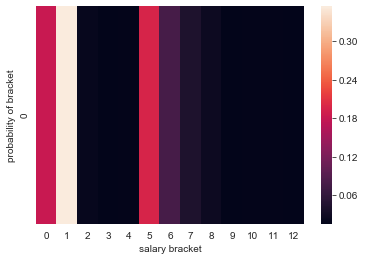

10-20,000


In [42]:
sns.heatmap(model.predict_proba(X_test[48,:].reshape(1,-1)))
plt.xlabel('salary bracket')
plt.ylabel('probability of bracket')
plt.show()

print (y_test.iloc[48])

The heatmap below shows the numerical deviation from the true label for every test instance. If it is zero (black), the prediction was correct. You can observe that the heatmap is mostly dark which justifies the hypothesis. 

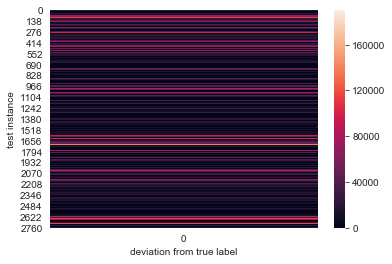

In [47]:
sns.heatmap(np.abs(np.subtract([int(np.char.split(s, '-').tolist()[-1].replace(',','')) for s in predictions], 
            [int(np.char.split(s, '-').tolist()[-1].replace(',','')) for s in y_test])).reshape(-1,1))
plt.xlabel('deviation from true label')
plt.ylabel('test instance')
plt.show()